# Analysis for Figure 1C SEC elutions

In [4]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import os
from functools import reduce
from itertools import chain
from sympy import factorint
import glob
# import pyDOE2
from sklearn.utils import shuffle

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import ttest_ind



In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Figure_1_exports'
data_folder = './Figure_1_data'

### Uses data from eCM349

In [3]:
df = pd.read_excel(f'Fig1C-SEC all elution data.xlsx')
df

,Fluorphore,DNA_name,rep,volume,rep1,rep2,rep3
0,GFP,Blank,1,0,4889,4366,4363
1,GFP,Blank,1,250,56,64,78
2,GFP,Blank,1,500,128,151,131
3,GFP,Blank,1,750,104,92,120
4,GFP,Blank,1,900,129,136,153
...,...,...,...,...,...,...,...
397,Cy5,Cat,3,2100,48,48,54
398,Cy5,Cat,3,2600,30,35,37
399,Cy5,Cat,3,3100,11,16,14
400,Cy5,Cat,3,3600,6,7,6


## Notes about the data:
* The 0 volume samples are for the samples measured prior to SEC
* rep indicates biological replicate
* sub_rep indicates technical replicate measurements as there is veriance in the split GFP binding

In [4]:
data = df.set_index(['Fluorphore', 'DNA_name', 'rep', 'volume']).stack().reset_index().rename(columns={'level_4':'sub_rep',0:'AU'})
data = data.set_index(['DNA_name', 'rep', 'volume','sub_rep','Fluorphore']).unstack().reset_index()
data.columns = data.columns.droplevel()
data.columns = ['DNA_name', 'rep', 'volume','sub_rep','Cy5','GFP']
data = data[data['DNA_name'] != 'MscL']
data

,DNA_name,rep,volume,sub_rep,Cy5,GFP
0,AqpZ,1,0,rep1,1302,38239
1,AqpZ,1,0,rep2,1236,33528
2,AqpZ,1,0,rep3,1232,31119
3,AqpZ,1,250,rep1,1,54
4,AqpZ,1,250,rep2,1,54
...,...,...,...,...,...,...
445,Cat,3,3600,rep2,7,3454
446,Cat,3,3600,rep3,6,3609
447,Cat,3,4100,rep1,4,217
448,Cat,3,4100,rep2,2,142


## Statistical analysis

### Liposome Peak

In [5]:
t = data[data['volume'] == 1200]
aqpz = t[t['DNA_name'] == 'AqpZ']
cat = t[t['DNA_name'] == 'Cat']

blank = t[t['DNA_name'] == 'Blank']

cy5 = ttest_ind(aqpz['Cy5'],blank['Cy5'])[1]
gfp = ttest_ind(aqpz['GFP'],blank['GFP'])[1]
fold_diff = aqpz['GFP'].mean() / blank['GFP'].mean()
print(f'AqpZ:Blank - Cy5:{cy5}   GFP:{gfp}   diff:{fold_diff}')

cy5 = ttest_ind(aqpz['Cy5'],cat['Cy5'])[1]
gfp = ttest_ind(aqpz['GFP'],cat['GFP'])[1]
fold_diff = aqpz['GFP'].mean() / cat['GFP'].mean()

print(f'AqpZ:Cat - Cy5:{cy5}   GFP:{gfp}   diff:{fold_diff}')

cy5 = ttest_ind(cat['Cy5'],blank['Cy5'])[1]
gfp = ttest_ind(cat['GFP'],blank['GFP'])[1]
fold_diff = cat['GFP'].mean() / blank['GFP'].mean()
print(f'Cat:Blank - Cy5:{cy5}   GFP:{gfp}   diff:{fold_diff}')

AqpZ:Blank - Cy5:0.007425606589881421   GFP:1.2365274101079134e-11   diff:8.326968461703496
AqpZ:Cat - Cy5:0.06991132717484812   GFP:2.9956088697918486e-14   diff:12.625894599869877
Cat:Blank - Cy5:0.5903481991867223   GFP:0.3128308847674981   diff:0.6595151255095473


### Free protein peak

In [6]:
t = data[data['volume'] == 3100]
aqpz = t[t['DNA_name'] == 'AqpZ']
cat = t[t['DNA_name'] == 'Cat']

blank = t[t['DNA_name'] == 'Blank']

cy5 = ttest_ind(aqpz['Cy5'],blank['Cy5'])[1]
gfp = ttest_ind(aqpz['GFP'],blank['GFP'])[1]
fold_diff = aqpz['GFP'].mean() / blank['GFP'].mean()
print(f'AqpZ:Blank - Cy5:{cy5}   GFP:{gfp}   diff:{fold_diff}')

cy5 = ttest_ind(aqpz['Cy5'],cat['Cy5'])[1]
gfp = ttest_ind(aqpz['GFP'],cat['GFP'])[1]
fold_diff = aqpz['GFP'].mean() / cat['GFP'].mean()

print(f'AqpZ:Cat - Cy5:{cy5}   GFP:{gfp}   diff:{fold_diff}')

cy5 = ttest_ind(cat['Cy5'],blank['Cy5'])[1]
gfp = ttest_ind(cat['GFP'],blank['GFP'])[1]
fold_diff = cat['GFP'].mean() / blank['GFP'].mean()
print(f'Cat:Blank - Cy5:{cy5}   GFP:{gfp}   diff:{fold_diff}')

AqpZ:Blank - Cy5:0.009974761597718788   GFP:8.754821322795989e-07   diff:1.498691480081419
AqpZ:Cat - Cy5:0.035944098621407156   GFP:1.602776416895114e-11   diff:0.12928309837957155
Cat:Blank - Cy5:0.9375771502779789   GFP:7.892719811511504e-12   diff:11.592323349810993


## Plotting

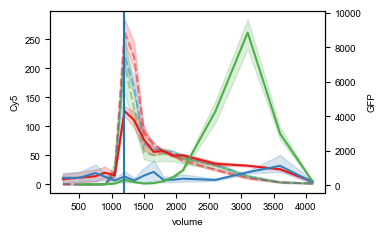

In [7]:
t = data[data['volume'] != 0]
# t = data
fig,ax = plt.subplots(figsize=[9*cm,6*cm])

sns.lineplot(data=t,x='volume',y='Cy5',hue='DNA_name',palette='Set1',ls='--',alpha=0.5,ax=ax,hue_order=['AqpZ','Blank','Cat'])
ax2 = plt.twinx()
sns.lineplot(data=t,x='volume',y='GFP',hue='DNA_name',palette='Set1', ax=ax2,hue_order=['AqpZ','Blank','Cat'])
ax.get_legend().remove()
ax2.get_legend().remove()
plt.axvline(1200)
# plt.savefig(f'{fig_folder}/all_profiles.svg',format='svg',dpi=300)

plt.show()

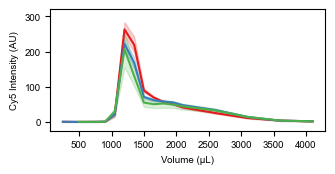

In [8]:
t = data[data['volume'] != 0]

fig,ax = plt.subplots(figsize=[9*cm,4*cm])
sns.lineplot(data=t,x='volume',y='Cy5',hue='DNA_name',palette='Set1',ax=ax,hue_order=['AqpZ','Blank','Cat'])
ax.get_legend().remove()

plt.ylim([-25,320])
plt.xlabel('Volume (μL)')
plt.ylabel('Cy5 Intensity (AU)')
plt.savefig(f'{fig_folder}/Fig1C-all_Cy5_profiles.svg',format='svg',dpi=300)

plt.show()

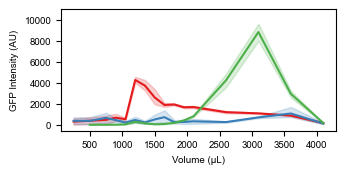

In [9]:
t = data[data['volume'] != 0]
fig,ax = plt.subplots(figsize=[9*cm,4*cm])

sns.lineplot(data=t,x='volume',y='GFP',hue='DNA_name',palette='Set1',ax=ax,hue_order=['AqpZ','Blank','Cat'])
ax.get_legend().remove()

plt.ylim([-500,11000])
plt.xlabel('Volume (μL)')
plt.ylabel('GFP Intensity (AU)')

plt.savefig(f'{fig_folder}/Fig1C-all_GFP_profiles.svg',format='svg',dpi=300)
plt.show()

### Data export

In [10]:
export = data[data['volume'] != 0].copy()
export = export.rename(columns={
    'rep':'Biological_rep',
    'sub_rep':'Technical_rep',
    'volume':'Elution_volume',
})

export.to_excel(f'./{data_folder}/Fig1C-SEC_data.xlsx')

### Calibration Curve

R2 score for fit: 0.995


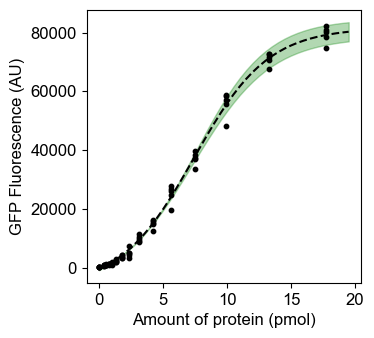

In [11]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

plt.rcParams['font.size'] = 12


df = pd.read_excel('./sample_calibration_curve.xlsx')
cutoff = 20
df = df[df['Cat pmol'] < cutoff]
xdata=np.array(df['Cat pmol'])
ydata=np.array(df['GFP'])

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is a mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
sigma_ab = np.sqrt(np.diagonal(pcov))

x_fit = np.arange(0,cutoff,0.5)

bound_upper = sigmoid(x_fit, *(popt + sigma_ab))
bound_lower = sigmoid(x_fit, *(popt - sigma_ab))

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

plt.fill_between(x_fit, bound_lower, bound_upper,
                 color = 'green', alpha = 0.3)

y_fit = sigmoid(x_fit,*popt)
y_pred = sigmoid(xdata, *popt)
score = round(r2_score(ydata, y_pred),3)
print(f'R2 score for fit: {score}')
plt.scatter(xdata,ydata,color='black',s=10)
plt.plot(x_fit,y_fit,color='black',ls='--')
plt.xlabel('Amount of protein (pmol)')
plt.ylabel('GFP Fluorescence (AU)')
# plt.xlim([0,10])
# plt.ylim([0,40000])

plt.savefig(f'{fig_folder}/Supp_fig-calibration_curve.svg',format='svg',dpi=300)

plt.show()

plt.rcParams['font.size'] = 7


R2 score for fit: 0.995


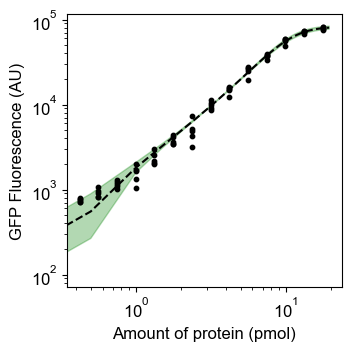

In [29]:
plt.rcParams['font.size'] = 12

fig,ax = plt.subplots(figsize=[9*cm,9*cm])


plt.fill_between(x_fit, bound_lower, bound_upper,
                 color = 'green', alpha = 0.3)
plt.xscale('log')
plt.yscale('log')

y_fit = sigmoid(x_fit,*popt)
y_pred = sigmoid(xdata, *popt)
score = round(r2_score(ydata, y_pred),3)
print(f'R2 score for fit: {score}')
plt.scatter(xdata,ydata,color='black',s=10)
plt.plot(x_fit,y_fit,color='black',ls='--')
plt.xlabel('Amount of protein (pmol)')
plt.ylabel('GFP Fluorescence (AU)')
# plt.xlim([0,10])
# plt.ylim([0,40000])


plt.savefig(f'{fig_folder}/Supp_fig-calibration_curve_log.png',format='png',dpi=300,bbox_inches='tight') # Can't render the svg file in illustrator so I switched to png for this figure
# plt.savefig(f'{fig_folder}/Supp_fig-calibration_curve_log.svg',format='svg',dpi=300,bbox_inches='tight')

plt.show()

plt.rcParams['font.size'] = 7


In [28]:
df.to_excel(f'./{data_folder}/Supp_Fig_1C-calibration_curve.xlsx')